# **Afghanistan War Analysis** 
- **Title**: Afghanistan Security during 2004 Election
- **Period**: 2001 - 2006
  
<img src="https://i0.wp.com/fightersweep.com/wp-content/uploads/2017/05/ac-130-gunship_flares.jpg?fit=2700%2C1517&ssl=1" width="1050px"> 

In [1]:
from wikipedia import search, WikipediaPage
import pandas as pd 
import numpy as np 
from urllib import request as curl 
from bs4 import BeautifulSoup
import os 
import json 
import re 
import boto3 
import multiprocessing as mp 
import math 
import pymssql 
import zipfile
import warnings 

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 

DATASET_PATH: str = os.path.join(os.path.expanduser("~/"), "Developments/Humanitarian/datasets")
pd.options.display.max_columns = 70
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

# **Helper Functions** 

In [2]:
def download_dataset(file_name: str):

    url: str = f"http://data.gdeltproject.org/events/{file_name}"
    try: 
        resp: str = curl.urlopen(url=url).read()

        # save the raw data in tmp dir 
        with open(f"/tmp/{file_name}", "wb") as f: 
            f.write(resp)
        f.close()

        # extract dataset 
        zipfile.ZipFile(file=os.path.join("/tmp", file_name) ).extractall(path=DATASET_PATH )
        
    except ConnectionError as e: 
        raise ConnectionError(f"[ ERROR ] Unable to connect to the following url: {url}. Please check the file name again !!!") from e 


# **GDELT Raw Data** 

In [12]:
gdelt_link: str = "http://data.gdeltproject.org/events/index.html" 
resp: bytes = curl.urlopen(url=gdelt_link).read()
soup = BeautifulSoup(resp)

pool = mp.Pool(processes=mp.cpu_count())

for link in soup.find_all("a"): 
    year: str = link.text[:4]
    if 'zip' in link.text and (year.isdigit() and int(year,10) in range(2001,2006) ):
        print("[ \033[92m+\033[0m ] downloading data --> %s" % (link))
        pool.apply_async(download_dataset, (link.text ,))

pool.close()
pool.join() 

[ + ] downloading data --> <a href="2005.zip">2005.zip</a>
[ + ] downloading data --> <a href="2004.zip">2004.zip</a>
[ + ] downloading data --> <a href="2003.zip">2003.zip</a>
[ + ] downloading data --> <a href="2002.zip">2002.zip</a>
[ + ] downloading data --> <a href="2001.zip">2001.zip</a>


## **Additional Data: (`PRIO.org`)** 

In [17]:
conflict_df: 'DataFrame' = pd.read_csv("/home/ubuntu/Developments/Humanitarian/datasets/ConflictRecurrenceDatabase.csv")
conflict_df.query("country == 'Afghanistan' ").head(5)

,conflict_new_id,conflict_name,dyad_new_id,dyad_name,type_of_violence,active_year,country,conflict_dyad,dyad_ep_start,dyad_ep_end,dyad_recurrence_date,dyad_ep_id,conf_ep_start,conf_ep_end,conf_recurrence_date,conf_ep_id,location,incompatibility,territory_name,type_of_conflict,region,conf_subid,conf_recurrence,confactor_recurrence,dyad_recurrence,factions,link_type_1,link_id_1,link_type_2,link_id_2,link_type_3,link_id_3,link_type_4,link_id_4,link_type_5,link_id_5,link_type_6,link_id_6,dyad_recurrence_years,conf_recurrence_years,conf_ep_low,conf_ep_best,conf_ep_high,dyad_ep_low,dyad_ep_best,dyad_ep_high,conf_ep_freq,dyad_ep_freq,cont_dyad,cont_conf
285,333.0,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,1.0,1,Afghanistan,333_724,1/7/1989,2/29/1992,9/28/1996,333_724_1992,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,1.0,0.0,0.0,5.0,NaN,4.0,333_736_2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,185567.0,201053.0,261121.0,2258.0,2546.0,3396.0,25936.0,75.0,0.0,0.0
286,333.0,Afghanistan: Government,724,Government of Afghanistan - Jam'iyyat-i Islami...,1.0,1,Afghanistan,333_724,9/28/1996,10/10/1996,NaN,333_724_1996,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,2.0,0.0,0.0,3.0,NaN,4.0,333_736_2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185567.0,201053.0,261121.0,314.0,314.0,314.0,25936.0,6.0,1.0,0.0
287,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,7/23/1989,8/27/1995,9/5/2002,333_726_1995,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,1.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,185567.0,201053.0,261121.0,8947.0,9144.0,15113.0,25936.0,195.0,0.0,0.0
288,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,9/5/2002,12/5/2003,5/16/2006,333_726_2003,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,3.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,185567.0,201053.0,261121.0,62.0,62.0,75.0,25936.0,8.0,0.0,0.0
289,333.0,Afghanistan: Government,726,Government of Afghanistan - Hizb-i Islami-yi A...,1.0,1,Afghanistan,333_726,5/16/2006,12/8/2006,3/11/2008,333_726_2006,1/1/1989,12/31/2018,NaN,333_2018,Afghanistan,2,NaN,4.0,3,3.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,185567.0,201053.0,261121.0,40.0,40.0,60.0,25936.0,9.0,0.0,0.0


## **Global Terrorism Database**
- Country: `Afghanistan` (1973 - 2020)

In [3]:
gdb: 'DataFrame' = pd.read_excel(os.path.join(DATASET_PATH, "globalterrorismdb_0522dist.xlsx") )
afghan_df: 'DataFrame' = gdb.query("country_txt == 'Afghanistan' ")
afghan_df['event_date'] = pd.to_datetime(afghan_df.apply(lambda row: "%s-%s-%s" %  (row.iyear, row.imonth, row.iday if row.iday > 0 else 1) , axis=1).tolist())

afghan_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
1862,197305010002,1973,5,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,0,0,9,Unknown,NaN,NaN,NaN,NaN,6,...,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,1973-05-01
7626,197902140010,1979,2,14,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,...,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,4.0,Hostage(s) killed (not during rescue attempt),1.0,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1979-02-14
9155,197908270005,1979,8,27,NaN,0,NaT,4,Afghanistan,6,South Asia,Ghazni,Ghazni,33.542622,68.415329,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,19,...,0.0,NaN,NaN,1,3.0,Minor (likely < $1 million),30000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN,1979-08-27
9217,197909090001,1979,9,9,NaN,0,NaT,4,Afghanistan,6,South Asia,Herat,Herat,34.346722,62.197315,1.0,0,NaN,NaN,1,1,1,-9,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,18,...,1.0,0.0,0.0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,-9,-9,NaN,1979-09-09
31128,198705310003,1987,5,31,NaN,0,NaT,4,Afghanistan,6,South Asia,Unknown,Unknown,NaN,NaN,5.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0.0,1,0,8,Unarmed Assault,NaN,NaN,NaN,NaN,14,...,2.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBRN Global Chronology,0,0,0,0,NaN,1987-05-31


## **Dataset Events in Afghanistan (`2001 - 2006`)** 

In [18]:
current_event: str = os.path.join(DATASET_PATH, "2001_2006_events.xlsx")
salvo_df: 'DataFrame' = afghan_df.query(" iyear >= 2001 and iyear <= 2006 ")
salvo_df.to_excel(current_event )

# save current event 
s3_bucket = boto3.client('s3')
s3_bucket.upload_file(Filename=current_event, Bucket="worldevents", Key=f"Afghanistan/{os.path.basename(current_event)}")

salvo_df.head(5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,event_date
71689,200101070007,2001,1,7,NaN,1,2001-01-10,4,Afghanistan,6,South Asia,Bamyan,Yakawlang,34.733333,66.966667,1.0,0,Yakawlang town and the surrounding district,1/7/2001: Taliban militia regained control of ...,1,1,1,0,NaN,NaN,0.0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,14,...,NaN,0.0,0.0,-9,NaN,NaN,NaN,NaN,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sources provide different accounts of the numb...,"""Taliban recapture central Afghan district,"" A...","""Taleban killed hundreds of Afghans - reports,...","""Afghanistan - Taleban accused of mass killing...",UMD Schmid 2012,0,0,0,0,NaN,2001-01-07
71772,200101220006,2001,1,22,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,Near a United Nations building and the unoccup...,1/22/2001: A bomb exploded near the unoccupied...,1,1,1,0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,"A cement wall was damaged, as was a tree",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Bomb explodes near Iranian Embassy, UN buildi...","""Blasts shake Afghan capital,"" Agence France-P...","""Fifth explosion in week hits Afghan capital,""...",UMD Schmid 2012,-9,-9,1,1,NaN,2001-01-22
71822,200102010001,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,Near the ministry of education in downtown Kabul,2/1/2001: A bomb exploded near the Ministry of...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,Windows in near-by stores were broken in the e...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01
71825,200102010005,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,In front of the tribal affairs ministry in dow...,2/1/2001: A bomb hidden in a sewer drain explo...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,2,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,A brick wall in front of the ministry was dama...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01
71826,200102010006,2001,2,1,NaN,0,NaT,4,Afghanistan,6,South Asia,Kabul,Kabul,34.516895,69.147011,1.0,0,The compound of the Kabul Hotel in downtown Kabul,2/1/2001: A bomb exploded in compound of the T...,1,1,1,0,NaN,NaN,1.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,1,...,0.0,0.0,0.0,1,4.0,Unknown,NaN,Several windows were broken in the explosion,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Update 1 - Three explosions in Afghan capital...","""Three explosions rock Kabul; no one hurt,"" As...","""Three explosions rock Afghan capital,"" Agence...",UMD Schmid 2012,-9,-9,0,-9,"200102010001, 200102010005, 200102010006",2001-02-01


## **Current Events** 

In [10]:
seasons: Dict = {'Summer': range(6,9), 
                 'Autumn': range(9,12), 
                 'Winter': [12,1,2],
                 'Spring': range(3,7) } 

current_event: str = os.path.join(DATASET_PATH, "2001_2006_events.xlsx")
salvo_df: 'DataFrame' = pd.read_excel(current_event)
salvo_df['Month'] = salvo_df['event_date'].apply(lambda row: row.month_name())
salvo_df['DayName'] = salvo_df['event_date'].apply(lambda row: row.day_name())
salvo_df['season'] = salvo_df['imonth'].apply(lambda row: 'Summer' if row in seasons.get('Summer') else 'Autumn' if row in seasons.get('Autumn') else 'Spring' if row in seasons.get('Spring') else 'Winter')

## **Afghanistan War Timeline**

In [30]:
resp: WikipediaPage = WikipediaPage(search("War in Afghanistan" )[1])
afghan_war_timeline: 'DataFrame' = pd.DataFrame( [ {'Index': re.sub("=", "", row).strip().split(":")[0], 'Timeline':  re.sub("=", "", row).strip().split(":")[1].title() } for row in resp.content.split("\n")   if "==" in row and re.findall(r"[0-9]{1,}\–", row) ] ).set_index('Index')
afghan_war_timeline

,Timeline
Index,
2001–2002,Invasion And Early Operations
2003–2005,Taliban Resurgence
2006–2009,Escalating War And Nato Build-Up
2010–2013,Coalition Offensives And Strategic Agreements
2014–2017,Withdrawal And Increase Of Insurgency
2018–2020,Peace Overtures
2020–2021,Us Withdrawal


In [31]:
secret: 'SecretManagers' = boto3.client('secretsmanager')
server,user,password = list(json.loads(secret.get_secret_value(SecretId='afghan_project').get('SecretString')).values()) 
con: 'MSSQL' = pymssql.connect(server=server, user=user, password=password)
con.autocommit(True)
cursor = con.cursor() 

# Tbl: AfghanWar
# cursor.execute("CREATE DATABASE AfghanWar" )
# con.commit() 

## **Afghanistan: Distribution of Wounded and Fatailities**

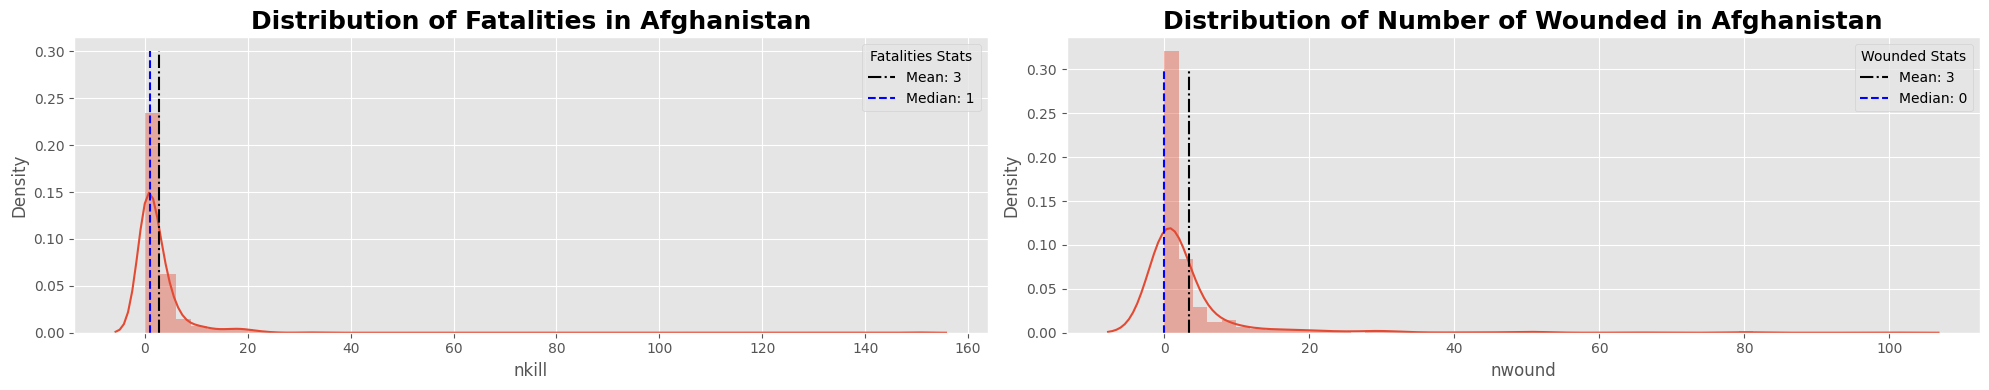

In [68]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,2,1) 

# Fatalities
sns.distplot(salvo_df['nkill'], ax=ax)
ax.set_title("Distribution of Fatalities in Afghanistan", fontweight='bold', fontsize=18)
mean_nkill: float = salvo_df['nkill'].mean() 
median_nkill: float = salvo_df['nkill'].median() 
ax.vlines(x=mean_nkill, ymin=0.0, ymax=0.3, label=f"Mean: {round(mean_nkill)}", linestyles="-.", color='black')
ax.vlines(x=median_nkill, ymin=0.0, ymax=0.3, label=f"Median: {math.trunc(median_nkill)}", linestyles="--", color='blue')
ax.legend(title="Fatalities Stats")

# Wounded
ax = fig.add_subplot(1,2,2) 
sns.distplot(salvo_df['nwound'], ax=ax)
ax.set_title("Distribution of Number of Wounded in Afghanistan", fontweight='bold', fontsize=18)
mean_nwound: float = salvo_df['nwound'].mean() 
median_nwound: float = salvo_df['nwound'].median() 
ax.vlines(x=mean_nwound, ymin=0.0, ymax=0.3, label=f"Mean: {round(mean_nwound)}", linestyles="-.", color='black')
ax.vlines(x=median_nwound, ymin=0.0, ymax=0.3, label=f"Median: {math.trunc(median_nwound)}", linestyles="--", color='blue')
ax.legend(title="Wounded Stats")

plt.tight_layout()

## **Events Happening in Afghanistan during (2001 - 2006)**
Explore the following: 
- Targeted Individual or groups during the incidents 
- Methods used during the attacked
- Places/Infrastructures targeted by the perpetrators 

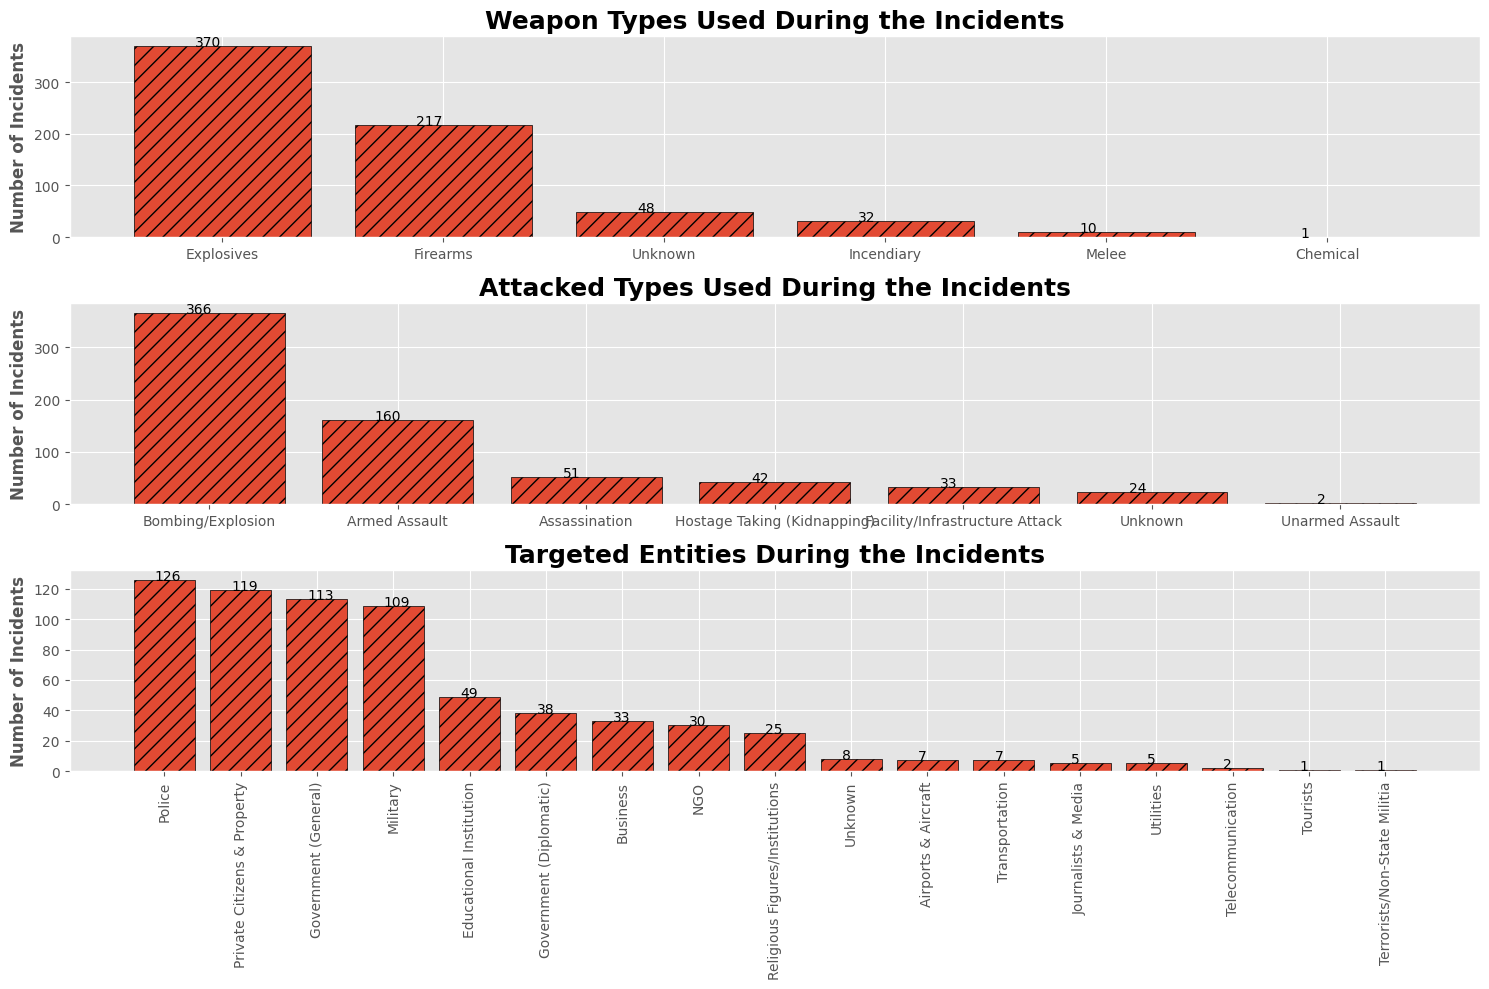

In [67]:
fig = plt.figure(figsize=(15,10))
titles: List[str] = ["Weapon Types Used During the Incidents", "Attacked Types Used During the Incidents", "Targeted Entities During the Incidents" ]
for index,col in enumerate(['weaptype1_txt', 'attacktype1_txt','targtype1_txt' ],1):
    ax = fig.add_subplot(3,1,index) 
    events, freqs = zip(*salvo_df[col].value_counts().to_dict().items())
    ax.bar(x=list(events), height=list(freqs), edgecolor='k', hatch="//")
    title: str = "%s" % ( re.sub("type1_txt", "", col).title() )
    ax.set_title( titles[index - 1 ]  , fontweight='bold', fontsize=18) 
    ax.set_ylabel("Number of Incidents", fontweight='bold')
    if index == 3: 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90) 

    for i,n_event in enumerate(freqs): 
        ax.annotate(text=f"{n_event}", xy=(i - 0.123, n_event) ) 
        
plt.tight_layout() 

## **Histogram: Type of Attacks**

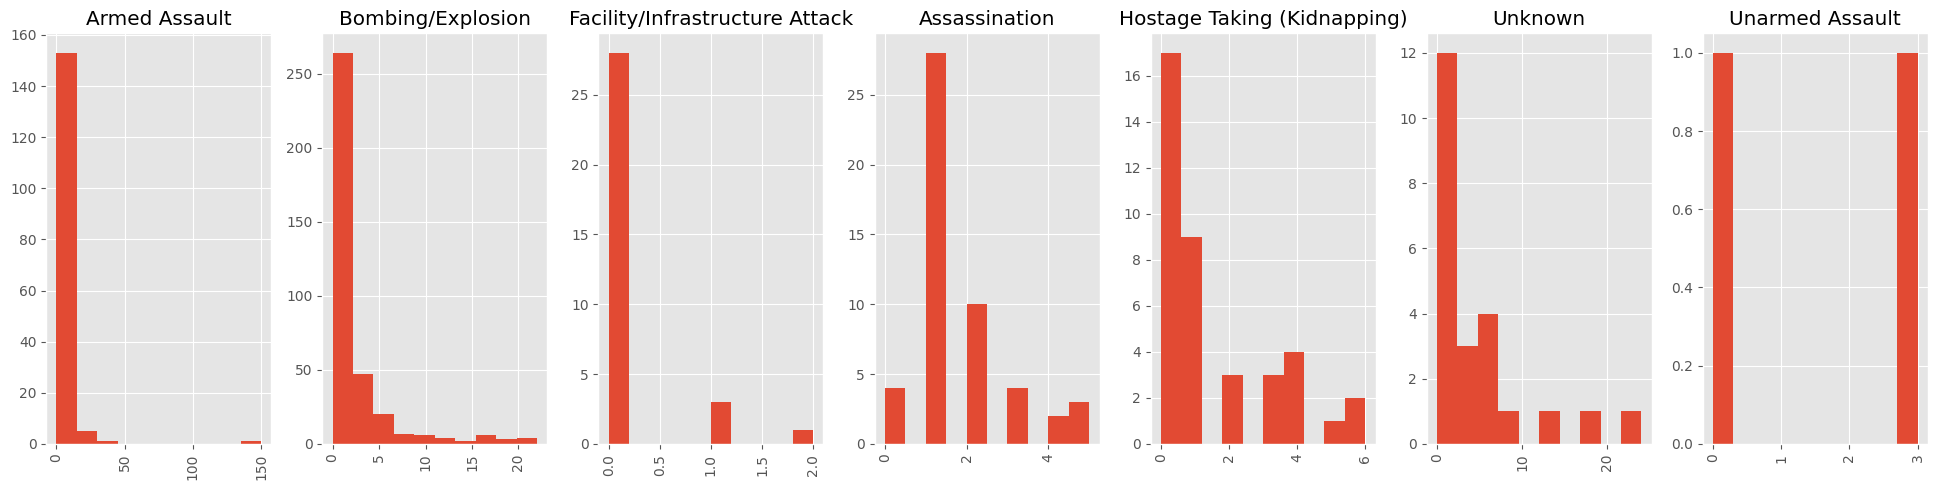

In [84]:
fig = plt.figure(figsize=(25,5)) 
for index,event in enumerate(salvo_df['attacktype1_txt'].unique(), 1): 
    ax = fig.add_subplot(1,9,index) 
    salvo_df.query(f"attacktype1_txt == '{event}' ").hist(by='attacktype1_txt', column='nkill', ax=ax)

plt.tight_layout() 

## **Boxplot: Main Incidents** 

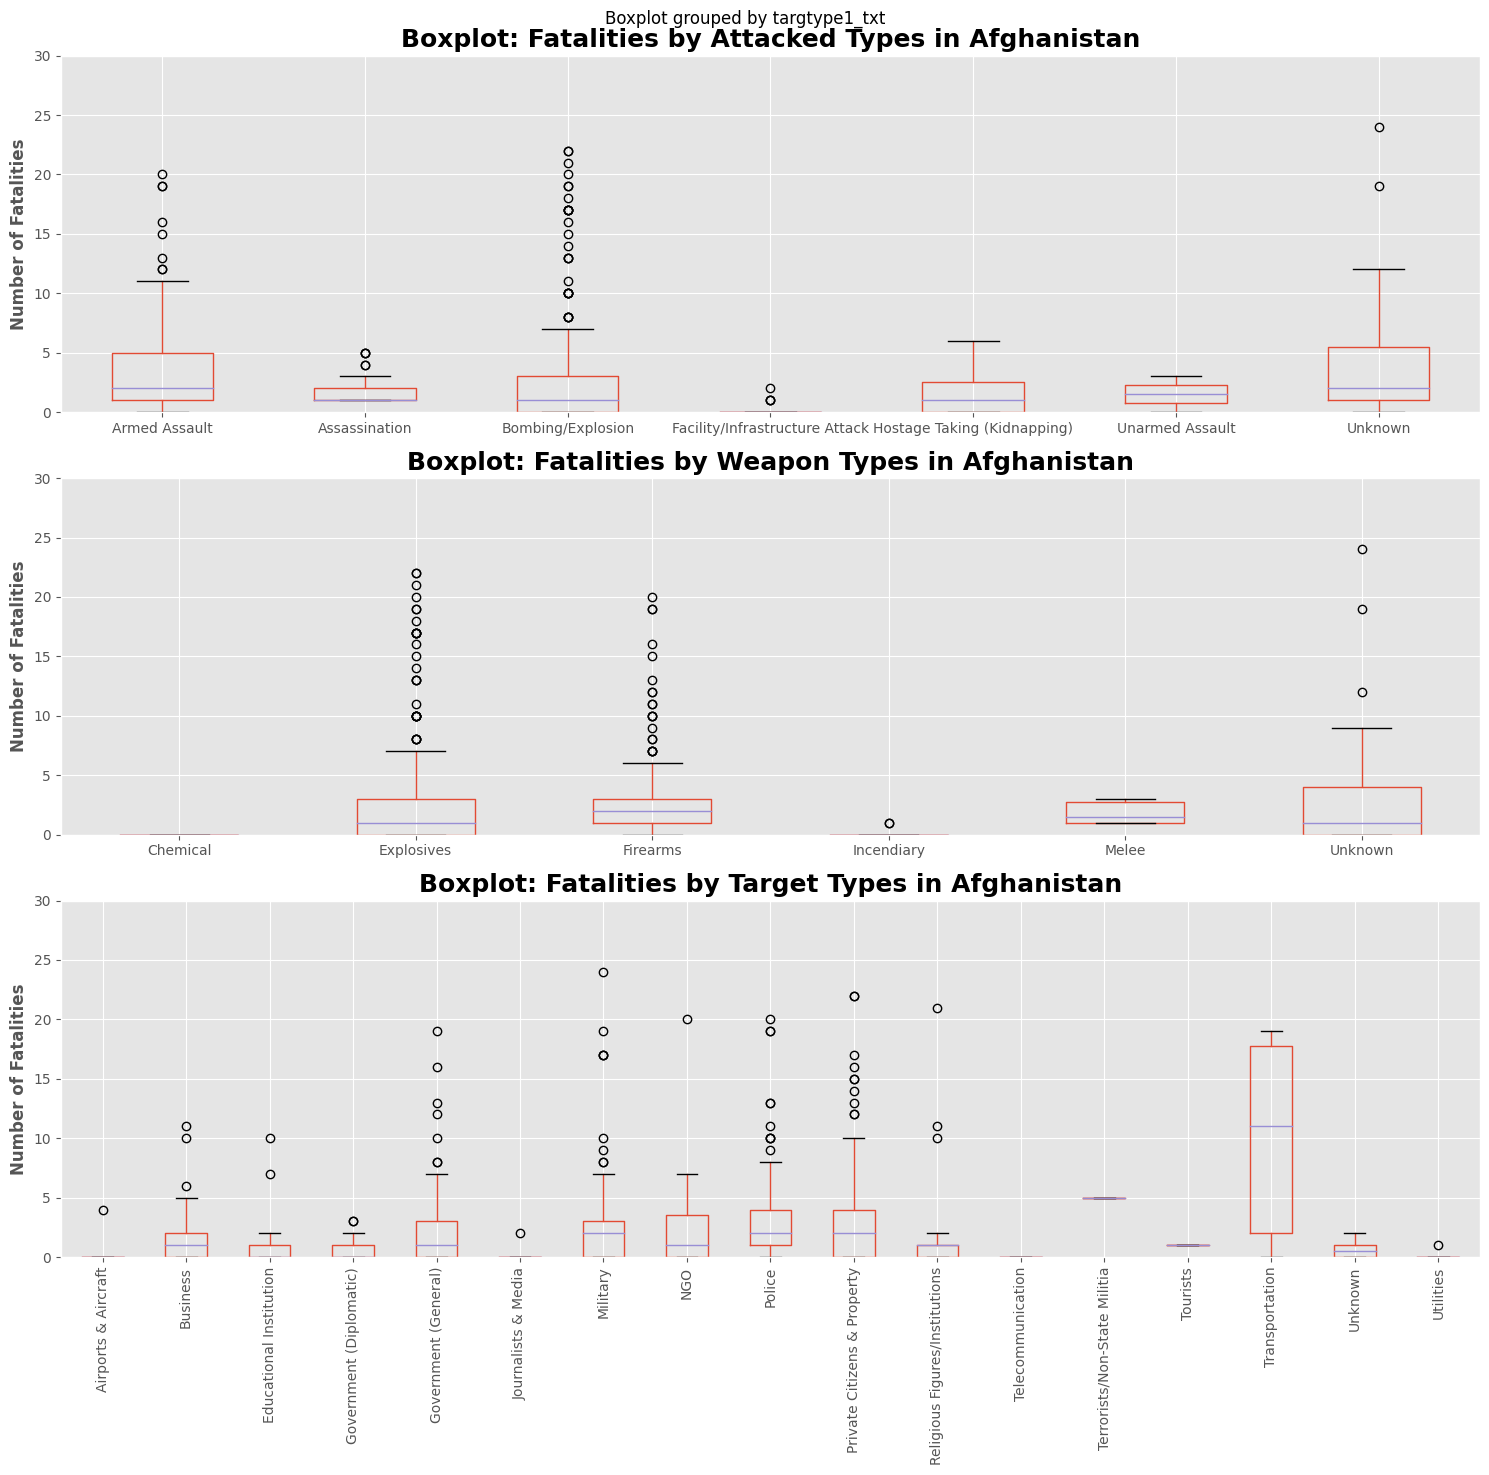

In [47]:
fig = plt.figure(figsize=(15,15)) 

# Attacked Types 
ax = fig.add_subplot(3,1,1)
salvo_df.query("success == 1 ").boxplot(by='attacktype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Attacked Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")

# Weapons used 
ax = fig.add_subplot(3,1,2)
salvo_df.query("success == 1 ").boxplot(by='weaptype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Weapon Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")

# Targets 
ax = fig.add_subplot(3,1,3)
salvo_df.query("success == 1 ").boxplot(by='targtype1_txt' , column='nkill', ax=ax) 
ax.set_ylim([0,30 ])
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.set_title("Boxplot: Fatalities by Target Types in Afghanistan", fontweight='bold', fontsize=18)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout() 

## **Methods Used and Targets During the Incidents**

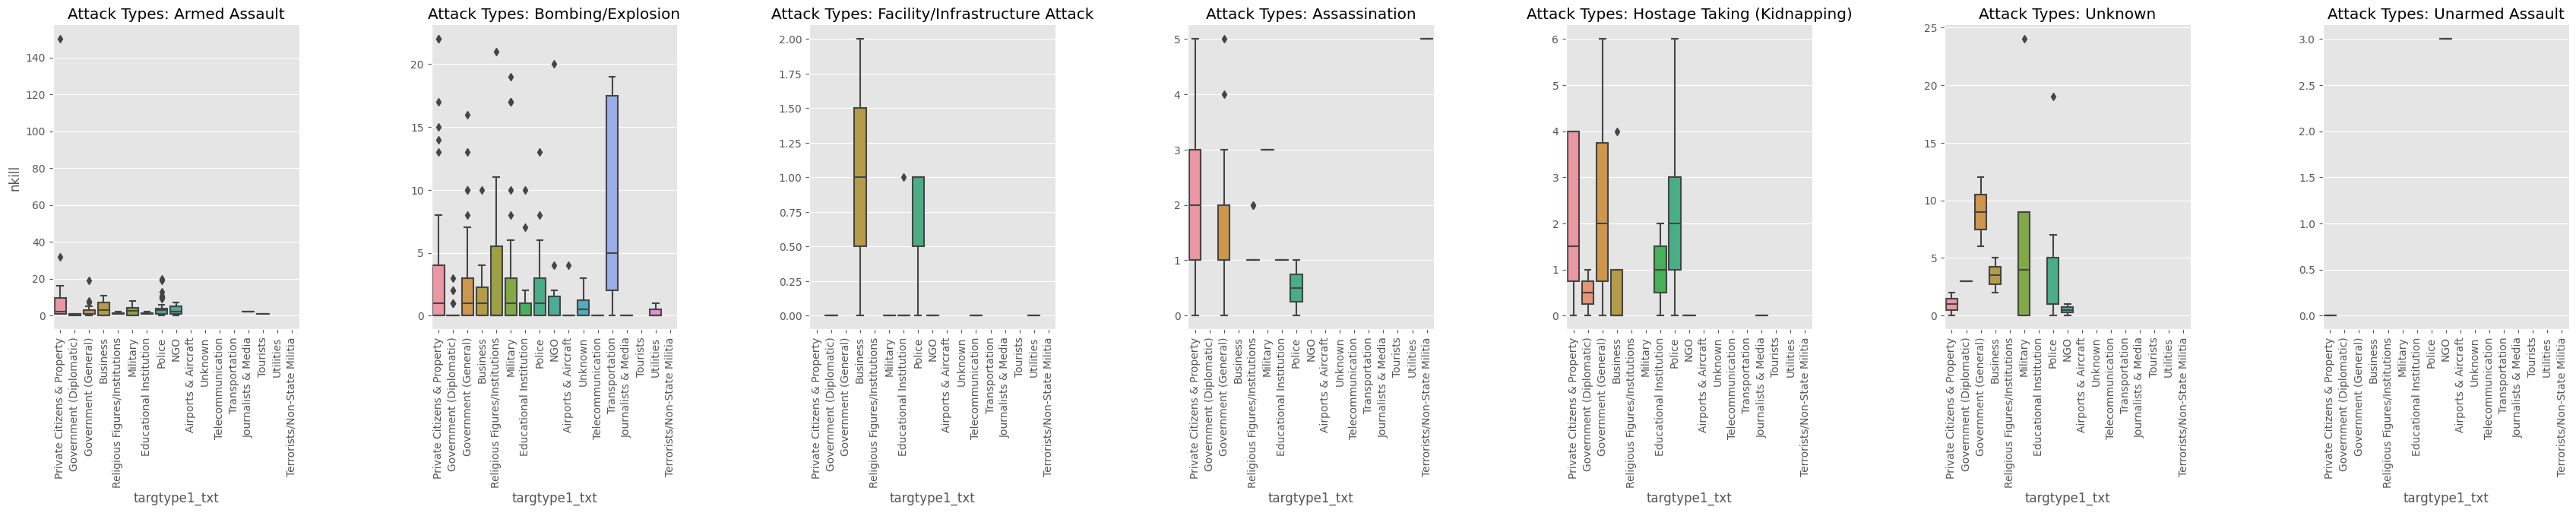

In [118]:
plt.rcParams['figure.figsize'] = (50,50)
ax = sns.catplot(data=salvo_df, col='attacktype1_txt',  x='targtype1_txt', y='nkill', kind='box', sharey=False)
for axis in ax.axes.ravel():
    axis.set_xticklabels(axis.get_xticklabels() , rotation=90)
    axis.set_title("Attack Types: %s" % (axis.title.get_text().split("=")[-1].strip() ) ) 

## **Attack Types Trends During (2001 - 2006)**
- Election: (October 9, 2004)
- Exploring the fatalities trends before, during, and after the Presidential Election (`Elected President Karzai`)

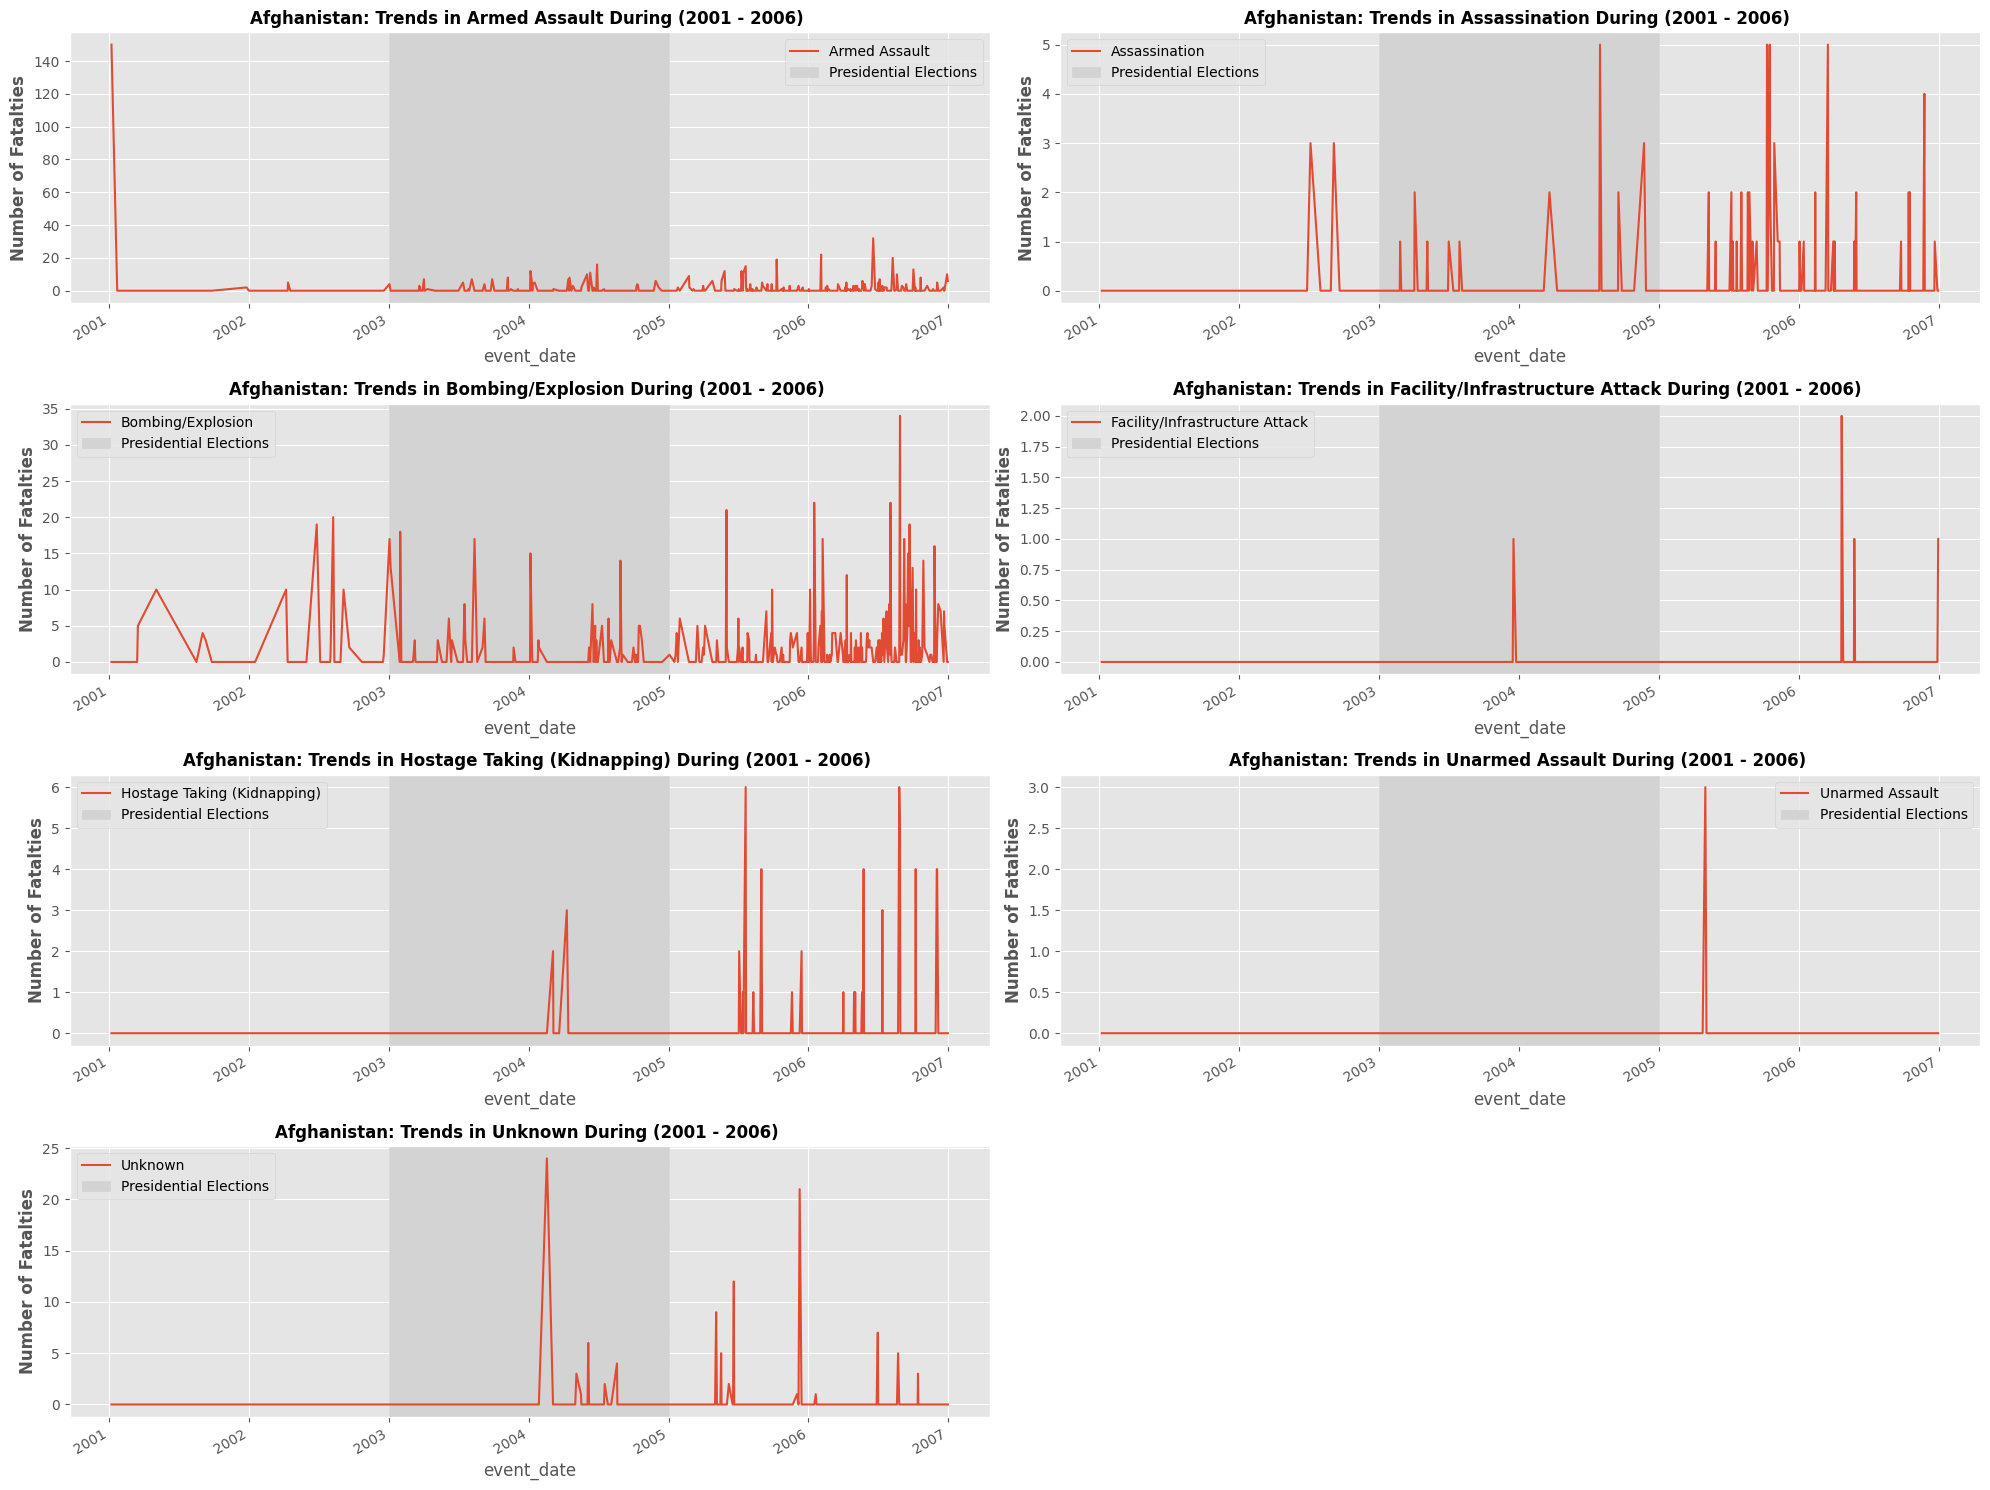

In [152]:
fig = plt.figure(figsize=(20,15))

events_tbl: 'DataFrame' = pd.pivot_table(data=salvo_df, index=['event_date'], columns=['attacktype1_txt'], values='nkill', aggfunc='sum').replace({np.nan:0.0})
for index,col in enumerate(events_tbl.columns.tolist(), 1):
    ax = fig.add_subplot(4,2,index) 
    events_tbl[col].plot(ax=ax) # .plot(ax=ax, marker='s', mec=2.3)
    ax.set_title("Afghanistan: Trends in %s During (2001 - 2006) " % (col), fontweight='bold', fontsize=12 )
    ax.set_ylabel("Number of Fatalties", fontweight='bold')
    ax.axvspan(xmin=pd.to_datetime("2003-01-01") , xmax=pd.to_datetime("2005-01-01"), edgecolor='k', color='lightgray', hatch="/", label="Presidential Elections" )
    ax.legend() 
    
plt.tight_layout() 

## **Public Holidays Afghanistan**

In [46]:
pd.io.html.read_html("https://en.wikipedia.org/wiki/Public_holidays_in_Afghanistan")[0][['Date', 'English Name']].set_index('Date')

,English Name
Date,
February 15,Liberation Day
March 21,Nowruz (New Day)
April 28,Mujahideen Victory Day
May 1,International Workers' Day
August 15,"""Afghan Jihad"" Victory Day[2]"
August 19,Afghan Independence Day
August 31,American Withdrawal Day[3]
September 9,Martyrs' Day
1 of Shawwal in the Islamic Calendar,Eid al-Fitr


## **Targeted Entities, Months, and Fatalities During (2001 - 2006) Incidents** 

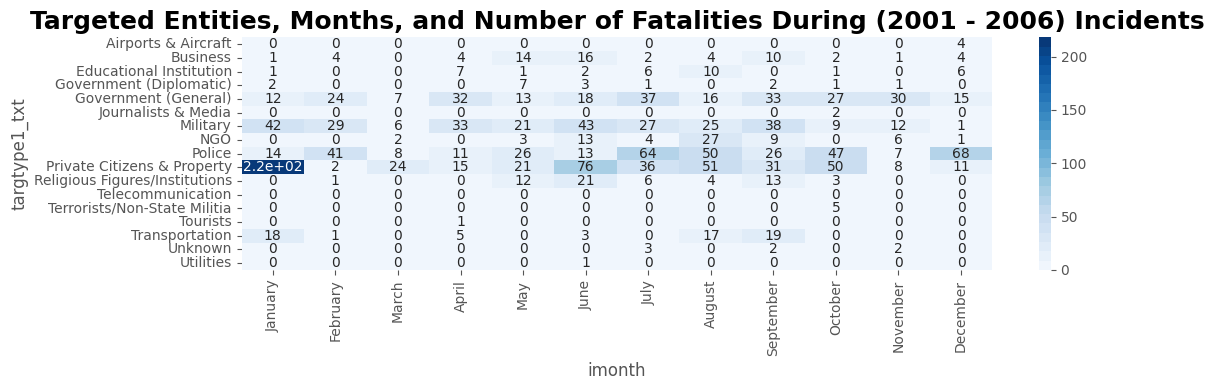

In [191]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot()
sns.heatmap(salvo_df.groupby(['targtype1_txt', 'imonth'])['nkill'].sum().unstack('imonth').replace({np.nan:0.0}).rename({ month:pd.to_datetime("2001-%s-01" % (month) ).month_name() for month in range(1,13) }, axis=1),
            cmap=ListedColormap(sns.color_palette(n_colors=25, palette='Blues')),
            annot=True)
ax.set_title("Targeted Entities, Months, and Number of Fatalities During (2001 - 2006) Incidents", fontweight='bold', fontsize=18)
plt.tight_layout() 

## **Perpetrators in Afghanistan**

In [201]:
pd.DataFrame(salvo_df['gname'].value_counts()).rename({'count': 'Number of Incidents'}, axis=1) 

,Number of Incidents
gname,
Taliban,396
Unknown,241
Al-Qaida,20
Hizb-I-Islami,6
Opposition Group,5
Haqqani Network,3
Anti-United States extremists,2
Jaish al-Muslimin (Army of the Muslims),2
Saif-ul-Muslimeen,1


## **Incidents involving the `Taliban`**

In [29]:
salvo_df.query("gname == 'Taliban' ").groupby(['imonth', 'iyear'])[['nkill', 'nwound']].sum().unstack('imonth').replace({np.nan:0.0}).rename(salvo_df[['imonth', 'Month']].drop_duplicates().sort_values(by='imonth').set_index('imonth').to_dict().get('Month'), axis=1)

nkill                                                          \
imonth January February March April   May  June  July August September   
iyear                                                                    
2001     150.0      0.0   0.0   0.0   0.0   0.0   0.0    0.0       3.0   
2002       0.0      0.0   0.0   5.0   0.0   0.0   0.0    0.0       0.0   
2003      13.0      1.0   3.0  10.0   3.0   1.0  15.0    7.0      20.0   
2004      26.0     24.0   3.0  21.0   3.0  56.0  14.0   10.0       2.0   
2005       7.0      9.0   6.0  16.0  17.0  17.0  74.0   20.0      33.0   
2006       9.0     64.0  22.0  34.0  36.0  43.0  37.0   69.0      67.0   

                                  nwound                                   \
imonth October November December January February March April   May  June   
iyear                                                                       
2001       0.0      0.0      0.0     0.0      0.0   0.0   0.0   0.0   0.0   
2002       0.0      0.0      0.0     0.0      0.0   0.0   0.0   4.0   0.0   
2003       0.0     11.0      2.0    50.0      3.0   6.0   0.0   6.0   8.0   
2004      22.0      9.0      2.0    50.0     10.0   0.0   9.0   0.0  15.0   
2005      37.0     20.0     37.0     5.0      0.0  33.0   0.0  11.0   4.0   
2006      28.0     24.0     41.0     3.0     52.0  10.0  62.0  33.0  14.0   

                                                         
imonth  July August September October November December  
iyear                                                    
2001     0.0    0.0       1.0     0.0      0.0      0.0  
2002     0.0    0.0       0.0     0.0      0.0      0.0  
2003     5.0    0.0      21.0     0.0      3.0     29.0  
2004    12.0    7.0       1.0    21.0      0.0      4.0  
2005    38.0   10.0      33.0    14.0     26.0     26.0  
2006    77.0   73.0      90.0    28.0     27.0     13.0

## **Deadliest Year in Afghanistan: 2006** 
- Types of attacks and targets by season

In [56]:
salvo_df.query("gname == 'Taliban' ").set_index('event_date')["2006":].groupby(['targtype1_txt','weaptype1_txt','season'])['nkill'].sum().unstack("weaptype1_txt").replace({np.nan:0.0}).astype(int)
# Escalation in 2006

weaptype1_txt                          Explosives  Firearms  Incendiary  \
targtype1_txt                  season                                     
Airports & Aircraft            Winter           4         0           0   
Business                       Spring           0         3           0   
                               Winter           4         0           0   
Educational Institution        Autumn           0         0           0   
                               Spring           7         1           0   
                               Summer           1         0           0   
                               Winter           0         0           0   
Government (Diplomatic)        Spring           2         1           0   
Government (General)           Autumn          40         2           0   
                               Spring           5        13           0   
                               Summer          15         0           0   
                               Winter           8        22           0   
Journalists & Media            Autumn           0         0           0   
Military                       Autumn          18         0           0   
                               Spring          13         0           0   
                               Summer          30         6           0   
                               Winter           8         0           0   
NGO                            Autumn           4         0           0   
                               Summer           0         2           0   
Police                         Autumn           0        23           0   
                               Spring           5        23           0   
                               Summer           5        37           0   
                               Winter          44        16           1   
Private Citizens & Property    Autumn           0         6           0   
                               Spring           4         8           0   
                               Summer           3        37           0   
                               Winter           0         0           0   
Religious Figures/Institutions Winter           1         0           0   
Transportation                 Autumn          19         0           0   
Unknown                        Summer           3         0           0   

weaptype1_txt                          Melee  Unknown  
targtype1_txt                  season                  
Airports & Aircraft            Winter      0        0  
Business                       Spring      1        0  
                               Winter      0        0  
Educational Institution        Autumn      0        0  
                               Spring      0        0  
                               Summer      0        0  
                               Winter      1        0  
Government (Diplomatic)        Spring      0        0  
Government (General)           Autumn      0        0  
                               Spring      0        1  
                               Summer      0        0  
                               Winter      2        0  
Journalists & Media            Autumn      0        0  
Military                       Autumn      0        0  
                               Spring      0        0  
                               Summer      0        0  
                               Winter      0        0  
NGO                            Autumn      0        0  
                               Summer      0        0  
Police                         Autumn      0        3  
                               Spring      4        1  
                               Summer      0       10  
                               Winter      0        1  
Private Citizens & Property    Autumn      0        4  
                               Spring      0        0  
                               Summer      0        0  
                               

## **Afghan Infrastructures and Provinces targeted by the Talibans**

In [222]:
salvo_df.query("gname == 'Taliban' ").groupby(['provstate', 'targtype1_txt'])['nkill'].agg('mean').unstack('targtype1_txt').replace({np.nan:0.0})

targtype1_txt,Airports & Aircraft,Business,Educational Institution,Government (Diplomatic),Government (General),Journalists & Media,Military,NGO,Police,Private Citizens & Property,Religious Figures/Institutions,Telecommunication,Terrorists/Non-State Militia,Tourists,Transportation,Unknown,Utilities
provstate,,,,,,,,,,,,,,,,,
Badakhshan,0.0,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Badghis,0.0,0.000000,0.000000,0.000000,5.000000,0.0,7.000000,3.333333,0.000000,5.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Baghlan,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Balkh,0.0,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Bamyan,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,150.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Daykundi,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,15.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Farah,0.0,1.666667,0.000000,0.000000,1.250000,0.0,1.000000,0.000000,2.500000,4.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Ghazni,0.0,2.000000,0.000000,1.000000,3.200000,0.0,10.000000,2.500000,1.600000,2.400000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Helmand,0.0,2.500000,0.600000,0.000000,4.166667,0.0,7.666667,2.666667,4.826087,2.200000,0.75,0.0,0.0,0.0,0.0,3.0,0.0


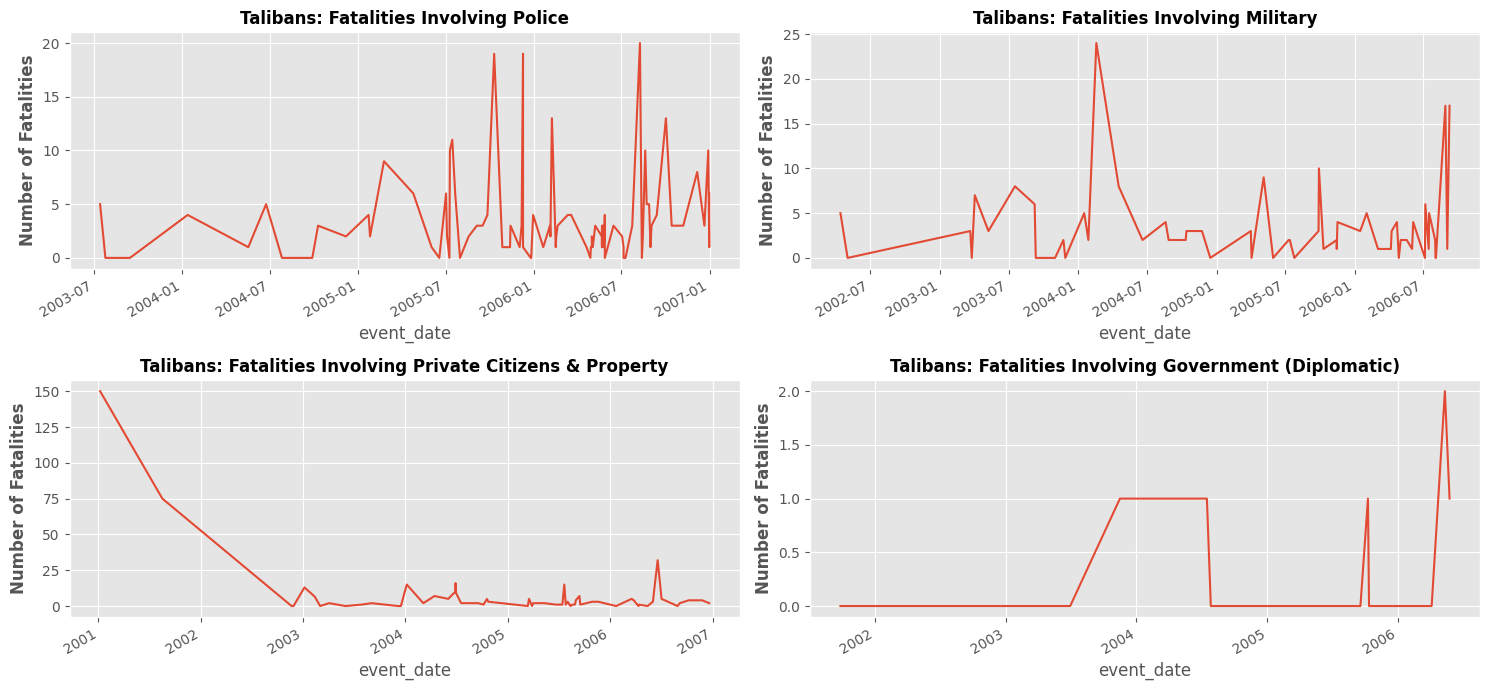

In [70]:
fig = plt.figure(figsize=(15,7)) 
for index, target in enumerate(['Police', 'Military', 'Private Citizens & Property', 'Government (Diplomatic)'], 1):
    ax = fig.add_subplot(2,2,index)
    salvo_df.query(f"gname == 'Taliban' and targtype1_txt == '{target}' ").set_index('event_date')['nkill'].interpolate().plot(ax=ax)
    ax.set_title(f"Talibans: Fatalities Involving %s" % (target) , fontweight='bold', fontsize=12)
    ax.set_ylabel("Number of Fatalities", fontweight='bold')
    
plt.tight_layout()

## **Modeling Fatalities** 